# LTV Prediction Using RR Curve Approximation

In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from pystatlab.metrics import smape
from pystatlab.num_methods import integrate
import warnings
warnings.filterwarnings('ignore')

Retention data: 
- `x`: `lifetime`
- `y`: `retention rate`

In [3]:
df = pd.read_csv('retention_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       365 non-null    int64  
 1   y       365 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.8 KB


In [4]:
df.head()

,x,y
0,1,0.280637
1,2,0.246665
2,3,0.208505
3,4,0.184475
4,5,0.168335


In [21]:
CPI = 0.62

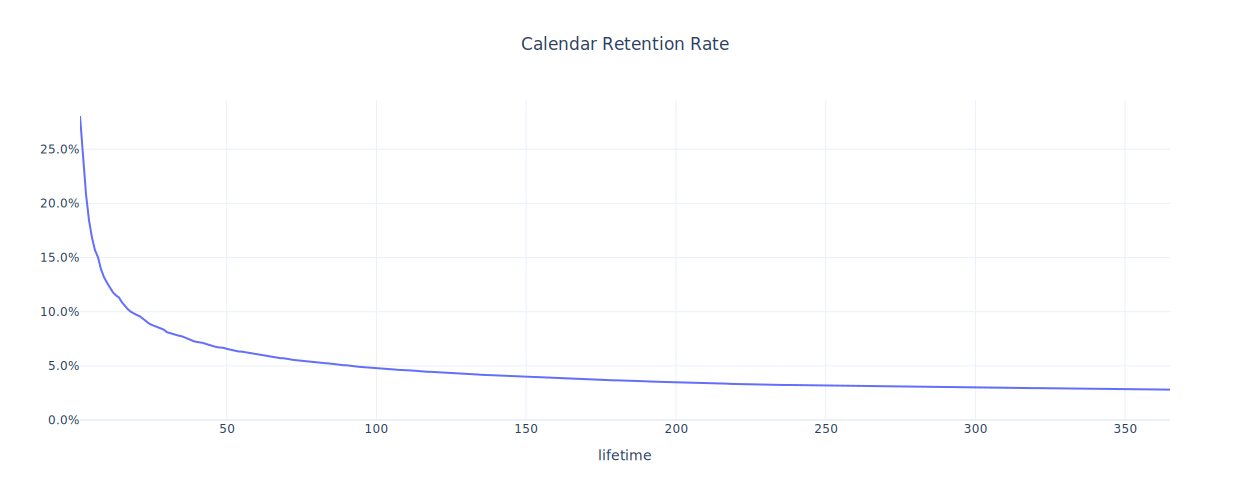

In [5]:
fig = go.Figure([go.Scatter(x=df['x'],y=df['y'],mode='lines')])
fig.update_layout(template='plotly_white', 
                  width=1250, 
                  hovermode='x',
                  xaxis_title='lifetime', 
                  yaxis={'rangemode':'tozero', 'tickformat':'.1%'},
                  title={'text':'Calendar Retention Rate','x':.5})
fig.show(renderer='svg')

In [6]:
train_feature = df['x'][:30]
train_target  = df['y'][:30]
test_feature  = df['x'][30:60]
test_target   = df['y'][30:60]

Power parametric functions:

In [7]:
def power_2(X,params):
    A,B = params
    return A*X**B

def power_3(X,params):
    A,B,C = params
    return A*X**B+C

def power_4(X,params):
    A,B,C,D = params
    return A*(X-D)**B+C

def power_5(X,params):
    A,B,C,D,E = params
    return A*(X-D)**B+X*C+E

Logarithmic parametric functions:

In [8]:
def log_2(X, params):
    A, B = params
    return A * np.log(X) + B

def log_3(X, params):
    A, B, C = params
    return A * np.log(B * X) + C

def log_4(X, params):
    A, B, C, D = params
    return A * np.log(B * (X - D)) + C

def log_5(X, params):
    A, B, C, D, E = params
    return A * np.log(B * (X - D)) + C * X + E

Hyperbolic parametric functions:

In [9]:
def hyperbolic_3(X, params):
    A, B, C = params
    return A / (X+B) + C

def hyperbolic_4a(X, params):
    A, B, C, D = params
    return A / (X**D + B) + C

def hyperbolic_4b(X, params):
    A, B, C, D = params
    return A / (np.log(X)**D + B) + C

def hyperbolic_5(X, params):
    A, B, C, E, D = params
    return A / (np.log(X+E)**D + B) + C 

Optimization function:

In [10]:
def mse(params,func, X, y):
    y_pred = func(X, params) 
    return np.mean((y - y_pred)**2)

Initial params:

In [11]:
np.random.seed(42)
initial_params = np.random.rand(5)

Selection 

In [12]:
print('Power funcs:')
for k,i in enumerate([power_2,power_3,power_4,power_5],2):
    bfgs = minimize(fun=mse, x0=initial_params[:k], args=(i, train_feature, train_target))
    print(f'BFGS sMAPE for {k} params:', smape(i(test_feature, bfgs.x), test_target))

Power funcs:
BFGS sMAPE for 2 params: 0.05732189369719218
BFGS sMAPE for 3 params: 0.34490989434776914
BFGS sMAPE for 4 params: 0.24433336541076953
BFGS sMAPE for 5 params: 0.23646126946501902


In [13]:
print('Log funcs:')
for k,i in enumerate([log_2,log_3,log_4,log_5],2):
    bfgs = minimize(fun=mse, x0=initial_params[:k], args=(i, train_feature, train_target))
    print(f'BFGS sMAPE for {k} params:', smape(i(test_feature, bfgs.x), test_target))

Log funcs:
BFGS sMAPE for 2 params: 0.34608424665838533
BFGS sMAPE for 3 params: nan
BFGS sMAPE for 4 params: nan
BFGS sMAPE for 5 params: 0.22940320302568581


In [14]:
print('Hyperbolic funcs:')
for k,i in zip([3,4,4,5],[hyperbolic_3,hyperbolic_4a,hyperbolic_4b,hyperbolic_5]):
    bfgs = minimize(fun=mse, x0=initial_params[:k], args=(i, train_feature, train_target))
    print(f'BFGS sMAPE for {k} params:', smape(i(test_feature, bfgs.x), test_target))

Hyperbolic funcs:
BFGS sMAPE for 3 params: 0.08261884393845162
BFGS sMAPE for 4 params: 0.008357466839327164
BFGS sMAPE for 4 params: 0.041588560493569585
BFGS sMAPE for 5 params: 0.06066425591662363


In [15]:
bfgs = minimize(fun=mse, x0=initial_params[:4], args=(hyperbolic_4a, df['x'][:60], df['y'][:60]))
print('R^2 score for predict on all data using hyperbolic_4a:',r2_score(hyperbolic_4a(df['x'], bfgs.x), df['y']))

R^2 score for predict on all data using hyperbolic_4a: 0.9929488191703887


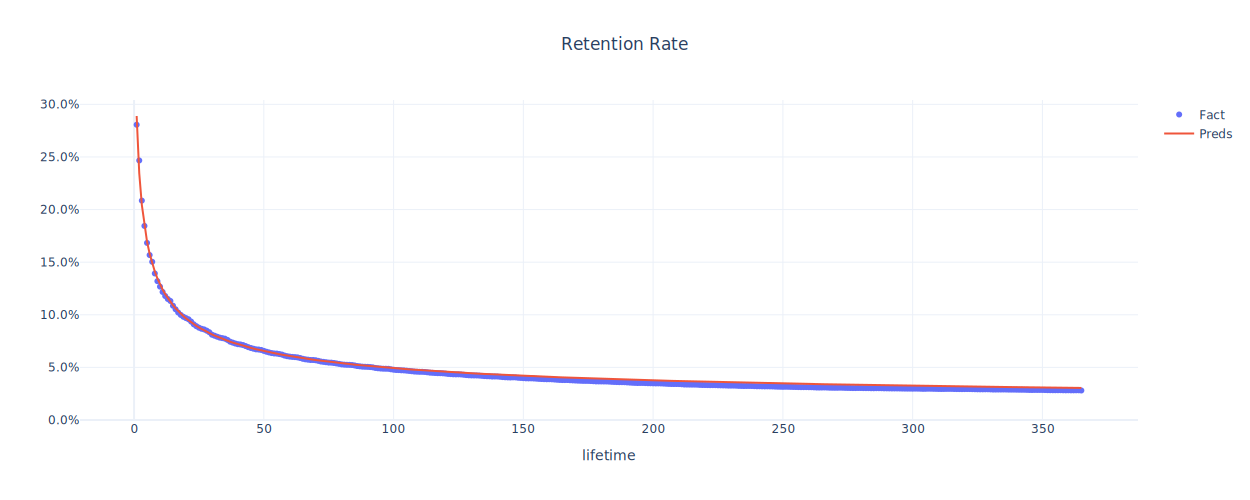

In [16]:
fig = go.Figure([
    go.Scatter(x=df['x'],y=df['y'],mode='markers', name='Fact'),
    go.Scatter(x=df['x'],y=hyperbolic_4a(df['x'], bfgs.x),mode='lines', name='Preds'),
                ])

fig.update_layout(template='plotly_white', 
                  width=1250, 
                  hovermode='x',
                  xaxis_title='lifetime', 
                  yaxis={'rangemode':'tozero', 'tickformat':'.1%'},
                  title={'text':'Retention Rate','x':.5})
fig.show(renderer='svg')

In [17]:
np.random.seed(42)
arpdau = np.random.uniform(low=0.036,high=0.042, size=14) + np.sin(np.arange(14) / 8 * 2 * np.pi) * 0.005 

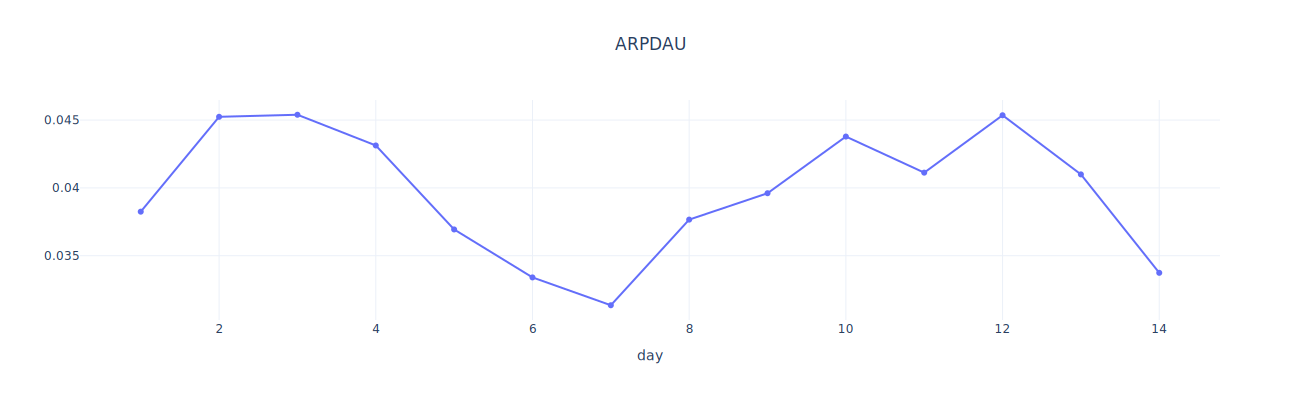

In [18]:
fig = go.Figure([
    go.Scatter(x=df['x'][:14],y=arpdau,mode='lines+markers')])
fig.update_layout(template='plotly_white', 
                  hovermode='x', 
                  title={'text':'ARPDAU','x':.5}, 
                  xaxis_title='day',
                  width=1300, 
                  height=400)
fig.show(renderer='svg')

In [19]:
def hyperbolic_integration(X):
    return hyperbolic_4a(X,bfgs.x)

In [22]:
lifetime = integrate(hyperbolic_integration, 1,365)+1
LTV = lifetime * arpdau.mean()
ROAS = LTV / CPI
print('CPI:', CPI)
print('LTV:', LTV)
print('ROAS: {:.2%}'.format(ROAS))

CPI: 0.62
LTV: 0.7380958392916516
ROAS: 119.05%
